In [17]:
# Install:
!pip install transformers datasets

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm
import random
import os
from itertools import product
import json

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torchvision import datasets,transforms
import torch.nn.functional as F
from torch.utils.data import TensorDataset,DataLoader,RandomSampler,SequentialSampler

#tokenizer
from transformers import BertTokenizer, RobertaTokenizer
#model
from transformers import BertModel, RobertaModel
#use the AdamW optimizer which implements gradient bias correction & weight decay
from transformers import BertForSequenceClassification,get_linear_schedule_with_warmup

from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
import logging

In [19]:
if torch.cuda.is_available():
    n_gpu = torch.cuda.device_count()
    print(f'number of gpu: {n_gpu}')
    print(f'cuda name: {torch.cuda.get_device_name(0)}')
    print('GPU is on')
else:
    print('GPU is off')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def set_seed(seed):
    # os.environ['PYTHONHASHSEED'] = str(seed)
    # os.environ['TF_CUDNN_DETERMINISTIC'] = 'true'
    # os.environ['TF_DETERMINISTIC_OPS'] = 'true'

    #basic seed
    np.random.seed(seed)
    random.seed(seed)

    #pytorch seed
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

GPU is off


In [20]:
def data_generator(dataset_name=None, subsample=None, target_label=None):
  # load the dataset from huggingface, only use the training set
  if dataset_name == 'amazon':
    dataset = load_dataset("amazon_polarity")
    label = np.array(dataset['train']['label'])

  elif dataset_name == 'yelp':
    dataset = load_dataset("yelp_review_full")
    label = np.array(dataset['train']['label'])

  elif dataset_name == 'imdb':
    dataset = load_dataset("imdb")
    label = np.array(dataset['train']['label'])

  elif dataset_name == 'agnews':
    dataset = load_dataset("ag_news")
    label = np.array(dataset['train']['label'])

  elif dataset_name == '20news':
    dataset = load_dataset("SetFit/20_newsgroups")
    groups = [['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x'],
          ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey'],
          ['sci.crypt', 'sci.electronics', 'sci.med', 'sci.space'],
          ['misc.forsale'],
          ['talk.politics.misc', 'talk.politics.guns', 'talk.politics.mideast'],
          ['talk.religion.misc', 'alt.atheism', 'soc.religion.christian']]

    def flatten(l):
        return [item for sublist in l for item in sublist]

    label = []
    for _ in tqdm(dataset['train']['label_text']):
      if _ not in flatten(groups):
        raise NotImplementedError

      for i, g in enumerate(groups):
        if _ in g:
          label.append(i)
          break
    label = np.array(label)

  else:
    raise NotImplementedError

  # transfer the origin dataset to the anomaly detection dataset
  if dataset_name == 'amazon' or dataset_name == 'imdb':
    # here we switch the label as negative is anomaly
    idx_n = np.where(label==1)[0]
    idx_a = np.where(label==0)[0]

    # transfer the label
    label[idx_n] = 0
    label[idx_a] = 1

    # subsample will be always 95% normal, 5% anomalies
    idx_n = np.random.choice(idx_n, int(subsample * 0.95), replace=False)
    idx_a = np.random.choice(idx_a, int(subsample * 0.05), replace=False)
    idx = np.append(idx_n, idx_a)
    random.shuffle(idx)

    text = dataset['train'][idx]['content'] if dataset_name == 'amazon' else dataset['train'][idx]['text']
    label = label[idx]

  elif dataset_name == 'agnews' or dataset_name == '20news':
    print(f'Normal label: {target_label}')

    idx_n = np.where(label==target_label)[0]
    idx_a = np.where(label!=target_label)[0]

    label[idx_n] = 0
    label[idx_a] = 1

    # subsample
    if int(subsample * 0.95) > sum(label == 0):
      pts_n = sum(label == 0)
      pts_a = int(0.05 * pts_n / 0.95)
    else:
      pts_n = int(subsample * 0.95)
      pts_a = int(subsample * 0.05)

    idx_n = np.random.choice(idx_n, pts_n, replace=False)
    idx_a = np.random.choice(idx_a, pts_a, replace=False)
    idx = np.append(idx_n, idx_a)
    random.shuffle(idx)

    text = dataset['train'][idx]['text']
    label = label[idx]

  elif dataset_name == 'yelp':
    # remove the neural review
    idx_n = np.where((label==3) | (label==4))[0]
    idx_a = np.where((label==0) | (label==1))[0]

    label[idx_n] = 0
    label[idx_a] = 1

    # subsample
    idx_n = np.random.choice(idx_n, int(subsample * 0.95), replace=False)
    idx_a = np.random.choice(idx_a, int(subsample * 0.05), replace=False)
    idx = np.append(idx_n, idx_a)
    random.shuffle(idx)

    text = dataset['train'][idx]['text']
    label = label[idx]

  del dataset

  # 去除特殊字符
  text = [_.strip().replace('<br />', '') for _ in tqdm(text)]

  print(f'number of normal samples: {sum(label==0)}, number of anomalies: {sum(label==1)}')

  return text, label

def embedding_NLP(text=None, label=None, max_len=512, save=True, plot=True, save_name=None, cuda=torch.cuda.is_available()):
  # extract embedding vector from the pretrained NLP model

  # tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
  # encoder = BertModel.from_pretrained("bert-base-uncased")

  tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
  encoder = RobertaModel.from_pretrained("roberta-base")

  if cuda:
    encoder.cuda()
  encoder.eval()

  encoding = tokenizer(list(text), return_tensors='pt', padding=True, truncation=True)
  input_ids = encoding['input_ids']; input_ids = input_ids[:, :max_len]
  attention_mask = encoding['attention_mask']; attention_mask = attention_mask[:, :max_len]
  dataloader = DataLoader(TensorDataset(input_ids, attention_mask), shuffle=False, batch_size=8, drop_last=False)

  # The embedding see https://github.com/huggingface/transformers/issues/7540
  embedding_list = []

  with torch.no_grad():
    for batch in tqdm(dataloader):
      if cuda:
        batch = tuple(d.cuda() for d in batch)
      input, mask = batch
      embedding = encoder(input_ids=input, attention_mask=mask)
      # embedding = torch.mean(embedding.last_hidden_state, dim=1)
      embedding = embedding.pooler_output
      embedding_list.append(embedding.cpu().numpy())

  X = np.vstack(embedding_list)
  y = np.array(label)

  np.savez_compressed(os.path.join('', save_name + '.npz'), X=X, y=y)

  if plot:
    # visualization
    X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X[:1000])
    y_tsne = np.array(y[:1000])

    plt.scatter(X_tsne[y_tsne==0, 0], X_tsne[y_tsne==0, 1], color='blue')
    plt.scatter(X_tsne[y_tsne==1, 0], X_tsne[y_tsne==1, 1], color='red')
    plt.title(save_name)
    plt.show()

In [21]:
# DeepOD default parameters

# subsample = 10000
# set_seed(42)

# for dataset_name in ['amazon', 'yelp', 'imdb', 'agnews', '20news']:
#   if dataset_name == 'agnews':
#     for target_label in [0, 1, 2, 3]:
#       text, label = data_generator(dataset_name, subsample=subsample, target_label=target_label)
#       embedding_NLP(text=text, label=label, save_name=dataset_name + '_' + str(target_label))

#   elif dataset_name == '20news':
#     for target_label in [0, 1, 2, 3, 4, 5]:
#       text, label = data_generator(dataset_name, subsample=subsample, target_label=target_label)
#       embedding_NLP(text=text, label=label, save_name=dataset_name + '_' + str(target_label))

#   else:
#     text, label = data_generator(dataset_name, subsample=subsample)
#     embedding_NLP(text=text, label=label, save_name=dataset_name)

# Margarida's experiments

In [22]:
from datasets import load_dataset
dataset = load_dataset("amazon_polarity")

Generating test split: 100%|██████████| 400000/400000 [00:00<00:00, 921656.93 examples/s]


In [23]:
dataset['train'][0]


{'label': 1,
 'title': 'Stuning even for the non-gamer',
 'content': 'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'}

Cloudtrail dataset

In [24]:
# Colab drive import

# from google.colab import drive
# drive.mount('/content/drive')
# %ls drive/MyDrive/HyGLAD


In [25]:
import json
import re
import numpy as np
import csv

with open('../mini-cloudtrail/cloudtrail.log') as f:
    lines = []
    ids = []
    for line in f:
        lines.append(line)
        m = re.search("'eventID': '([\d\w-]+)'", line)
        if not m:
            raise ValueError()
        id = m.group(1)
        ids.append(id)

text = np.array(lines)

with open('../mini-cloudtrail/anomaly_label.csv') as f:
    reader = csv.reader(f)
    label_dict = {}
    for r in reader:
        if r[1] == 'Label':
            continue
        elif r[1] == 'Normal':
            label_dict[r[0]] = 0
        elif r[1] == 'Anomaly':
            label_dict[r[0]] = 1

labels = np.array([label_dict[id] for id in ids])


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 18/18 [00:28<00:00,  1.59s/it]


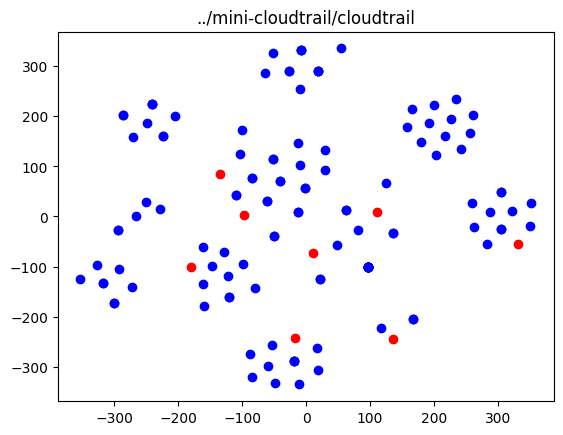

In [27]:
# text should be a 1-dim np array of strings
# label should be a same-dimension np array of 0/1
# save name is the desired output name
embedding_NLP(text=text, label=labels, save_name='../mini-cloudtrail/cloudtrail')